# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos epsilon-greedy en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.



This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [1]:
#@title Copiar el repositorio.



## Librerias

In [2]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/eml_k_bandit')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, GradientPreference
from arms import ArmNormal, ArmBernoulli, ArmBinomial, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret

['c:\\Users\\migue\\OneDrive\\Documentos\\GitHub\\k_brazos_VLB', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\python310.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\lib', 'C:\\Users\\migue\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0', '', 'C:\\Users\\migue\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages', 'C:\\Users\\migue\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\win32', 'C:\\Users\\migue\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\win32\\lib', 'C:\\User

## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

Este código realiza el experimento del bandido multi-brazo. Para ello se ejecutan ejecuciones (`runs`) y pasos (`steps`), registrando recompensas promedio, porcentaje de selecciones óptimas y el arrepentimiento que es la diferencia entre la recompensa esperada del brazo óptimo y la del brazo seleccionado. Cada algoritmo elige un brazo, obtiene su recompensa y actualiza su estimación, mientras que se almacenan estadísticas sobre el número de veces que se ha seleccionado cada brazo y su recompensa promedio. Finalmente, los resultados se promedian sobre las ejecuciones y se retornan como matrices de recompensas, selecciones óptimas, estadísticas de los brazos y el arrepentimiento.

In [3]:

def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret.


    arm_stats = [
        [{"arm": i + 1, "promedy_rewards": 0.0, "times_pulled": 0, "optimal": i==optimal_arm} for i in range(bandit.k)]
        for _ in range(len(algorithms))
        ]


    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.



    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                regret[idx, step] += current_bandit.get_expected_value(optimal_arm) - current_bandit.get_expected_value(chosen_arm)

                
                optimal_selections[idx, step] += (chosen_arm == optimal_arm)
                arm_stats[idx][chosen_arm]["times_pulled"] += 1
                arm_stats[idx][chosen_arm]["promedy_rewards"] += reward



    rewards /= runs
    regret /= runs
    for algo_idx in range(len(algorithms)):
        for arm_idx in range(bandit.k):
            if arm_stats[algo_idx][arm_idx]["times_pulled"] == 0:
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] = 0.0
            else:
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] /= arm_stats[algo_idx][arm_idx]["times_pulled"]
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] = np.round(arm_stats[algo_idx][arm_idx]["promedy_rewards"], 2)
            arm_stats[algo_idx][arm_idx]["times_pulled"] /= runs
            arm_stats[algo_idx][arm_idx]["times_pulled"] = round(arm_stats[algo_idx][arm_idx]["times_pulled"])
   

    optimal_selections /= runs

    return rewards, optimal_selections, arm_stats, regret


## Distribución Normal

### Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [4]:

# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [GradientPreference(k=k, alpha=0.1), GradientPreference(k=k, alpha=0.5), GradientPreference(k=k, alpha=1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)


Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Visualización de los resultados

#### Evolución Recompensa Promedio

Inicialmente mostraremos la evolucion de la recompensa promedio para los 3 algoritmos frente a los steps.

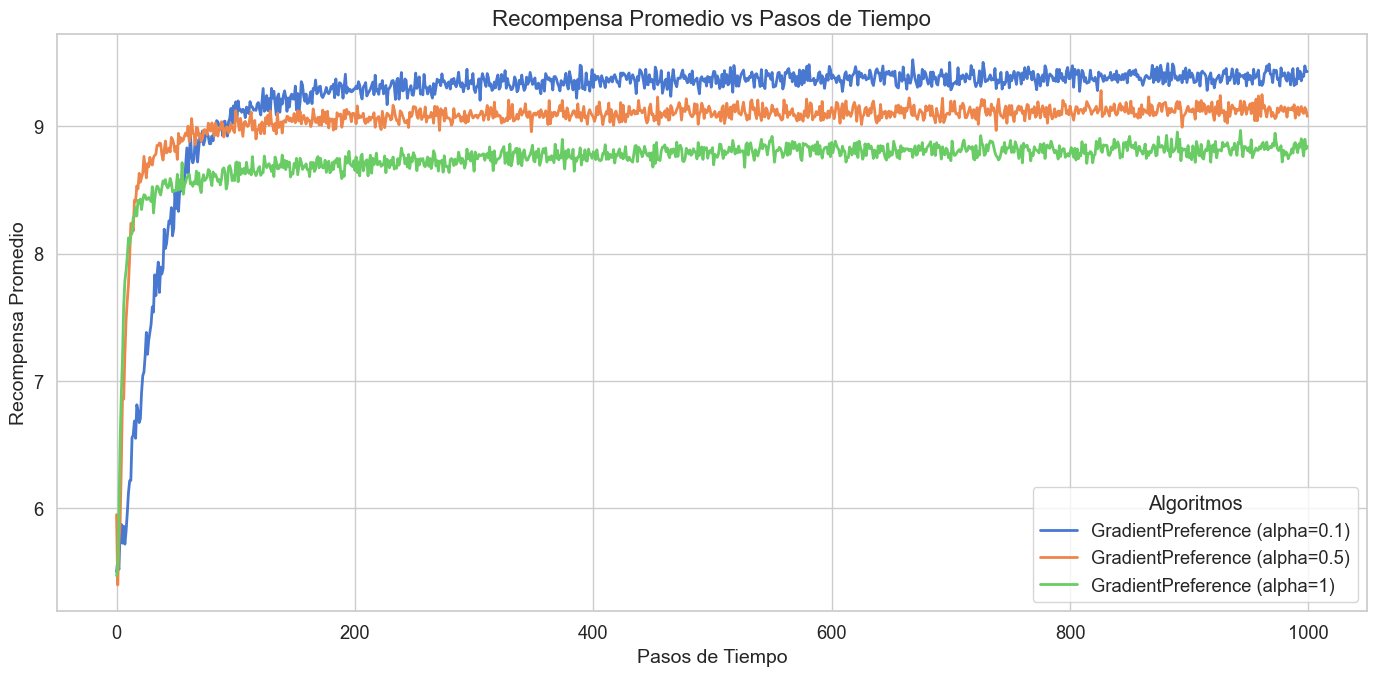

In [5]:

# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
# plot_optimal_selections(steps, optimal_selections, algorithms)


#### Análisis detallado de **"Recompensa Promedio vs Pasos de Tiempo"**
La imagen muestra un gráfico titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno del problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo o steps**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración). Esto ayudará a no explotar un mismo brazo y buscar más brazos que puedan maximizar la recompensa.
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1.
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.

---





#### Evolución Selección Brazo Optimo

Ahora continuamos mostrando la evolución del número de selecciones del brazo óptimo para cada uno de los 3 algoritmos.

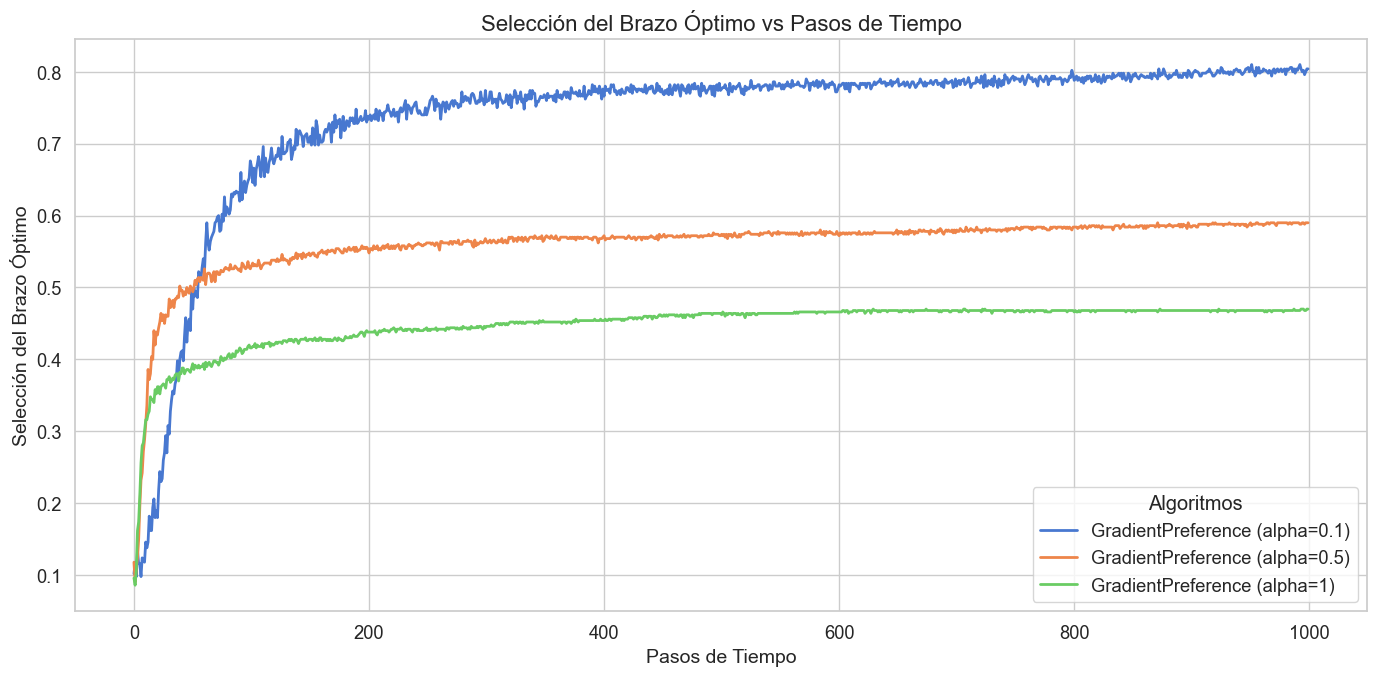

In [6]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### Análisis detallado de **"Selección del Brazo Óptimo vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado  **"Selección del Brazo Óptimo vs Pasos de Tiempo"**, donde se analiza el número de veces promedio que se elige el brazo óptimo  en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el promedio de **selecciones del brazo óptimo** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones. Por lo que será complicado que esta estrategia elija el brazo óptimo a no ser que lo elija en una primera instancia; ya que se dedicara a explotar el brazo elegido inicialmente.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración). Esto ayudará a no solo realizar explotación, sino también realizar exploración para encontrar el brazo óptimo.
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Selección del brazo óptimo:**
   - La línea **verde (ε=0.1)** alcanza rápidamente el brazo óptimo lo que indica que la estrategia con mayor exploración aprende más rápido cuál es el brazo óptimo y una vez conocido como sabe que es el que mejor recompensa promedio le puede dar, pues comienza a explotar esa opción.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1. Por lo que tardaría algo más en encontrar el brazo óptimo, pero también lo encontraría y lo comenzaría a explotar aunque más tardamente; haciendo así que tenga un menor número de tiradas de dicho brazo.
   - La línea **azul (ε=0)** al no tener exploración no logra encontrar el mejor brazo porque no explora nuevas opciones, por lo que nunca tira del brazo optimo y se dedica a explotar el brazo elegido inicialmente.

---

#### Estadisticas de los brazos

c:\Users\migue\OneDrive\Documentos\GitHub\k_brazos_VLB\plotting\plotting.py:129: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


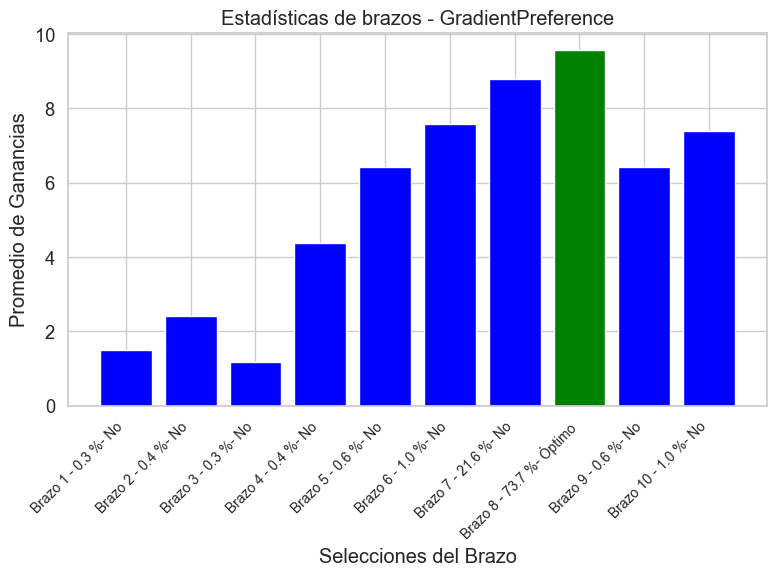

Recompensa Promedio del Brazo 1 : 1.51
Recompensa Promedio del Brazo 2 : 2.41
Recompensa Promedio del Brazo 3 : 1.17
Recompensa Promedio del Brazo 4 : 4.37
Recompensa Promedio del Brazo 5 : 6.42
Recompensa Promedio del Brazo 6 : 7.58
Recompensa Promedio del Brazo 7 : 8.8
Recompensa Promedio del Brazo 8 : 9.56
Recompensa Promedio del Brazo 9 : 6.41
Recompensa Promedio del Brazo 10 : 7.39


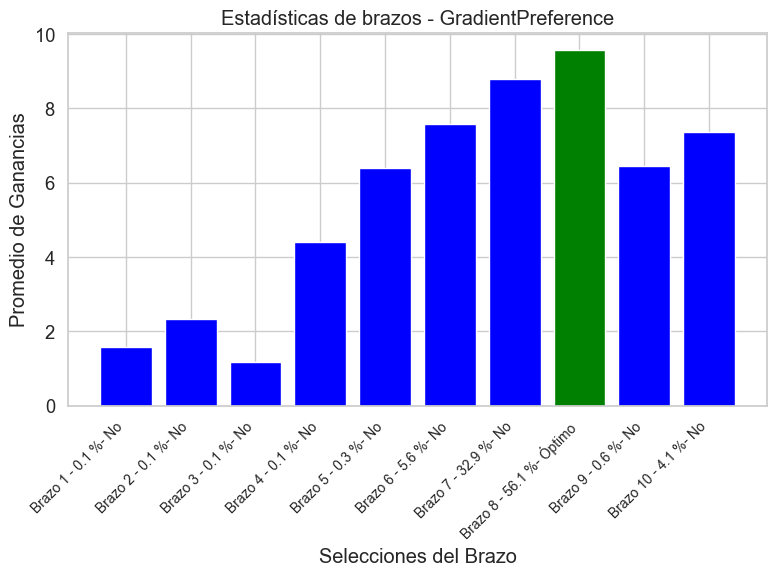

Recompensa Promedio del Brazo 1 : 1.58
Recompensa Promedio del Brazo 2 : 2.34
Recompensa Promedio del Brazo 3 : 1.17
Recompensa Promedio del Brazo 4 : 4.4
Recompensa Promedio del Brazo 5 : 6.39
Recompensa Promedio del Brazo 6 : 7.59
Recompensa Promedio del Brazo 7 : 8.8
Recompensa Promedio del Brazo 8 : 9.56
Recompensa Promedio del Brazo 9 : 6.45
Recompensa Promedio del Brazo 10 : 7.37


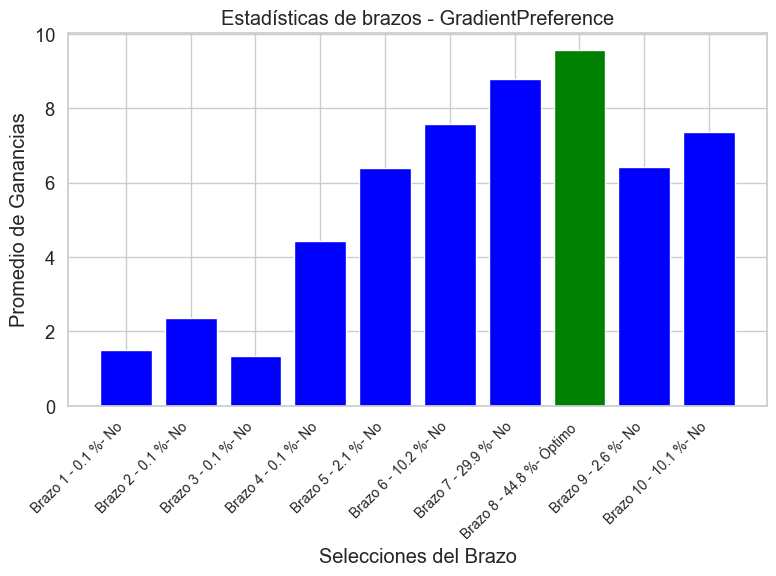

Recompensa Promedio del Brazo 1 : 1.5
Recompensa Promedio del Brazo 2 : 2.35
Recompensa Promedio del Brazo 3 : 1.33
Recompensa Promedio del Brazo 4 : 4.42
Recompensa Promedio del Brazo 5 : 6.39
Recompensa Promedio del Brazo 6 : 7.59
Recompensa Promedio del Brazo 7 : 8.8
Recompensa Promedio del Brazo 8 : 9.56
Recompensa Promedio del Brazo 9 : 6.41
Recompensa Promedio del Brazo 10 : 7.36


In [7]:
plot_arm_statistics(arm_stats, algorithms)

#### Análisis detallado de **"Estadísticas de los brazos"**

Las imágenes muestran un histograma donde podremos ver las estadísticas de los brazos, donde se analiza las estadísticas de los brazos en los algoritmos **ε-Greedy** en el problema del bandido multi-brazo. Algunas de las estadísticas que veremos serán la recompensa promedio, cuantas veces ha sido elegido cada brazo, si es el brazo óptimo y el número del brazo.


1. **Tres Histogramas que muestran las diferencias de valores de ε en el algoritmo ε-Greedy:**
   - La primera gráfica muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0, por lo que no tendrá ningún componente de exploración.
   - La segunda nos muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0.01, por lo que tendrá un 1% de probabilidad de exploración.
   - La tercera nos muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0.1, por lo que tendrá un 10% de probabilidad de exploración, haciendo así que haya un mayor componente de exploración.

2. **Estadísticas brazos**
   - En el primer histograma podemos ver el cómo el algoritmo a no tener exploración siempre se quedara en su primera opción elegida ya es que la mejor recompensa le ha dado hasta el momento. Entre ejecuciones podemos ver como elige entre el brazo 1 o el 2, aunque suele elegir el brazo 1, con un 95% de veces elegido. Como se puede ver ninguno de los 2 es el brazo óptimo. Además podemos ver como de media en las tiradas que sale parece que el brazo 2 da una mejor recompensa promedio.
   - En el segundo histograma ya podemos apreciar la exploración y el cómo se eligen una mayor cantidad de brazos y no se centra en solo explotar uno, podemos darnos cuenta de que alcanza el brazo óptimo que le otorga la mayor recompensa promedio y además es el brazo que una vez encontrado más veces se tiende a elegir dado que es el que mayor recompensa ha dado y que sabe que le seguira dando la recompensa más alta.
   - Ocurre un comportamiento similar al anterior, pero al tener un mayor porcentaje de exploración alcanza antes el brazo óptimo lo que hace que ya lo pueda elegir o explotar más veces al saber que es el brazo con la mayor recompensa que le ha dado. Y eso se ve reflejado en su porcentaje de tiradas promedio.

---

#### Evolución del arrepentimiento promedio.

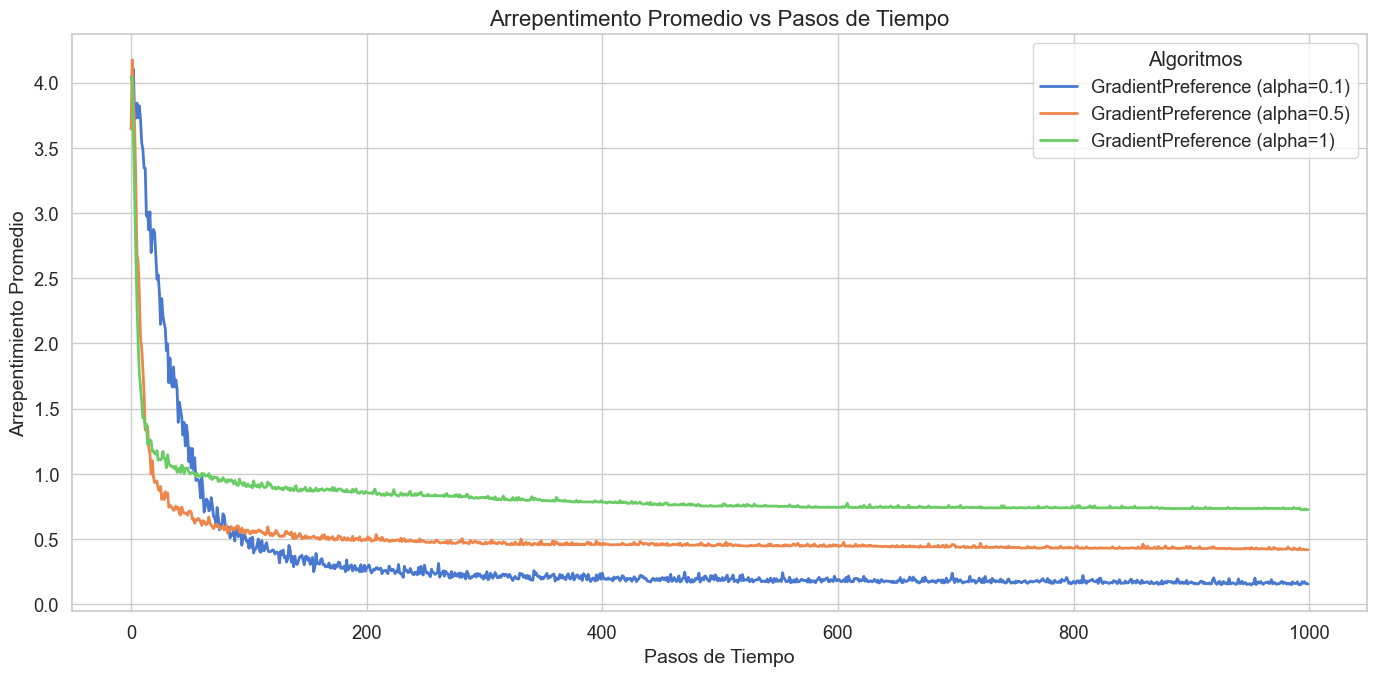

In [8]:
plot_regret(steps, regret_accumulated, algorithms)

#### Análisis detallado de **"Arrepentimiento Promedio vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado **"Arrepentimiento promedio vs Pasos de Tiempo"**, donde se analiza el arrepentimiento promedio de las estrategias del algoritmo **ε-Greedy** en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **arrepentimiento promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones. Por lo que esta estrategia difícilmente podría elegir el brazo óptimo a no ser que lo elija de primeras, lo que hará que el arrepentimiento aumente en este algoritmo; ya que al no escogerlo el arrepentimiento no decrecerá hasta que se encuentre el brazo óptimo.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Arrepentimiento promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente el brazo óptimo lo que indica que la estrategia con mayor exploración aprende más rápido qué brazo del bandit es óptimo. Esto trae como resultado que rápidamente encuentre el brazo óptimo y por ende empiece a obtener la mejor recompensa, haciendo así que su arrepentimiento decrezca rápidamente hasta estandarizarse en valores mínimos.
   - La línea **naranja (ε=0.01)** también muestra un decrecimiento, pero más lento en comparación con ε=0.1. Esto se debe a que como necesita más tiempo para encontrar el brazo óptimo, pues tirara más veces de brazos que no sean óptimos al tener un menor porcentaje de exploración, haciendo así que aumente el arrepentimiento hasta encontrar el brazo óptimo donde el arrepentimiento comienza a decrecer hasta estandarizarse en valores mínimos.
   - La línea **azul (ε=0)** al no tener exploración no logra encontrar el mejor brazo porque no explora nuevas opciones. Por lo que se mantiene con un arrepentimiento alto y de manera constante al nunca alcanzar el brazo óptimo.

---

### Conclusiones 

Hemos estudiado un **experimento de toma de decisiones secuenciales**, modelado con un **Bandido Multi-Brazzo**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandido) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **ε-Greedy** equilibra la exploración y la explotación:
- **Explotación (ε=0)**: Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.

Los gráficos confirman este comportamiento:
- **ε=0.1 (verde)** obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo y comenzar a explotarlo, además obtiene las mejores estadísticas y el arrepentimiento decrece rápidamente.
- **ε=0.01 (naranja)** explora menos, por lo que tarda más en converger a una recompensa alta y decrecer el arrepentimiento, aunque es cierto que encuentra el brazo óptimo, pero lo explota menos debido a que tarda más en encontrarlo.
- **ε=0 (azul)** no explora en absoluto y queda atrapado en una recompensa subóptima y un arrepentimiento estándar, además tiende a elegir siempre entre el brazo 1 o 2 y como no puede explorar solo se dedica a explotar el que haya elegido lo que le trae estos resultados.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor exploración (ε=0.1) alcanzan una recompensa alta más rápido y un arrepentimiento bajo más rápido. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.


#### **3. Utilidad Graficos**

El gráfico que nos muestra la recompensa promedio podemos utilizarlo para ver como los algoritmos mejoran en las recompensas obtenidas, para así hacernos a una idea de si están encontrando brazos que otorguen una buena recompensa e inclusive el brazo óptimo. Viendo el balance entre exploración y explotación nos ayuda a entender mejor el algoritmo.

La gráfica de Selección del Brazo Óptimo nos muestra la exploración y explotación, pudiendo ver así si los algoritmos encuentran el brazo óptimo y comienza a explotarlo, si realizan explotación de otros brazos o por ejemplo una falta de exploración para encontrar el brazo óptimo 

La gráfica de Estadísticas de Brazos nos muestra una serie de estadísticas de cada brazo como su porcentaje de selecciones, recompensas promedio de cada uno, su nombre o si es óptimo o no. Puede se útil para ver cuanta diferencia en recompensa promedio hay entre los brazos, si está explotando el brazo óptimo u otro brazo, la exploración o el porcentaje de selecciones de cada uno.

La gráfica del Arrepentimiento Promedio nos muestra el arrepentimiento promedio de cada uno de los algoritmos esto es útil, ya que nos ayuda a entender las elecciones de los brazos que están haciendo, si están eligiendo el brazo óptimo o si están explotando un brazo.

Las graficas más relevantes diría que son las 2 primeras. Porque con esas ya podemos hacernos a una idea de si se está seleccionando el brazo óptimo o no, si las recompensas van mejorando o no evolucionan. Entonces con estas 2 podemos básicamente hacernos a una idea de si se está eligiendo buenas opciones e inclusive se puede apreciar la falta de explotación. Las estadísticas de los brazos también es interesante aunque algo menos, lo más significativo para nosotros es el porcentaje de tiradas de cada brazo, ya que se puede apreciar muy fácilmente la explotación y la exploración. La última gráfica aunque interesante realmente no ofrece una información muy novedosa que no hayamos podido obtener con las anteriores.

#### **4. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **ε=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.

En conclusión para una distribución normal, **los gráficos muestran cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo**. 🚀

## Distribucion Binomial

### Ejecución del experimento

Volvemos a ejecutar el experimento pero esta vez los brazos seguiran una distribucion binomial.

In [9]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [GradientPreference(k=k, alpha=0.1), GradientPreference(k=k, alpha=0.5), GradientPreference(k=k, alpha=1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(probability=0.37, number=2), ArmBinomial(probability=0.95, number=2), ArmBinomial(probability=0.6, number=2), ArmBinomial(probability=0.73, number=2), ArmBinomial(probability=0.16, number=2), ArmBinomial(probability=0.06, number=2), ArmBinomial(probability=0.87, number=2), ArmBinomial(probability=0.71, number=2), ArmBinomial(probability=0.97, number=2), ArmBinomial(probability=0.02, number=2)
Optimal arm: 9 with expected reward=1.94


### Visualización de los resultados

#### Evolución Recompensa Promedio

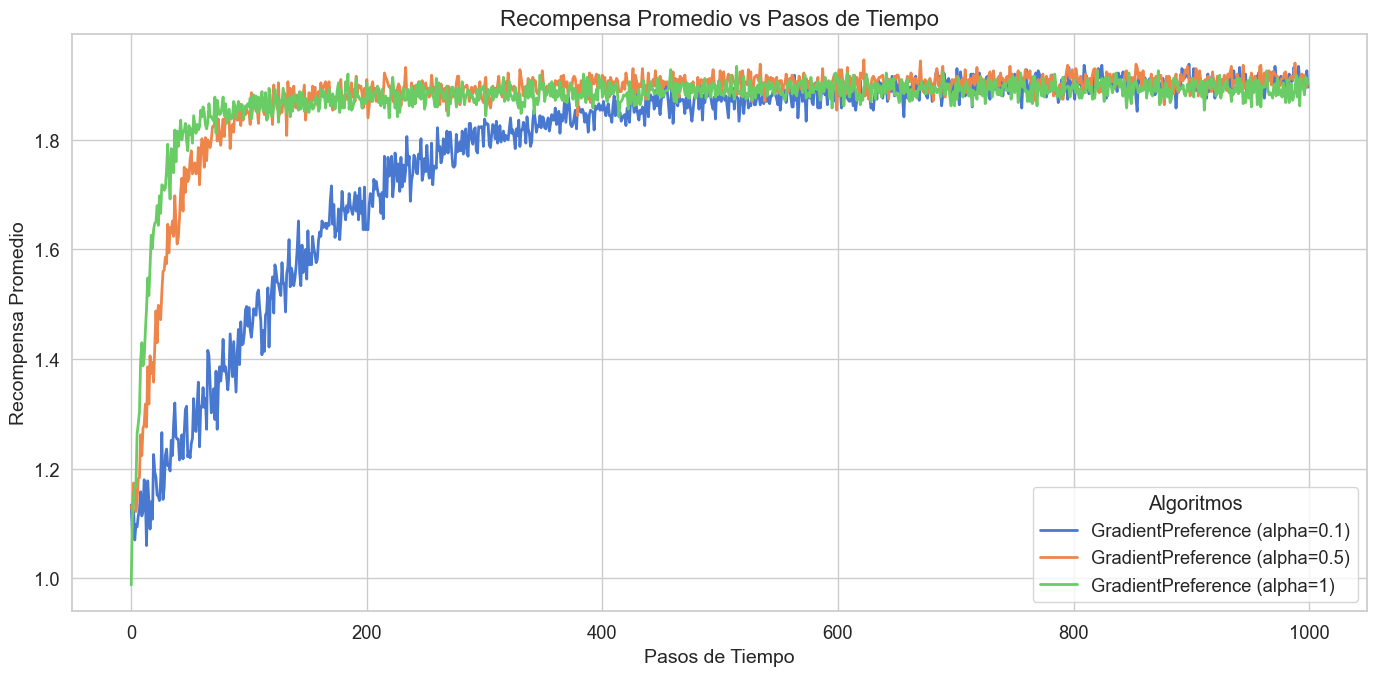

In [10]:
plot_average_rewards(steps, rewards, algorithms)

#### Análisis detallado de **"Recompensa Promedio vs Pasos de Tiempo"**
La imagen muestra un gráfico titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno del problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo o steps**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración). Esto ayudará a no explotar un mismo brazo y buscar más brazos que puedan maximizar la recompensa.
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1; aunque consigue alcanzar finalmente el valor del mismo.
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.


   Algo destacable es que las recompensas promedio son más bajas que para la distribución anterior, pero esto puede deberse simplemente al cómo esta distribución genera las recompensas haciendo que tengan un valor más bajo.

---

#### Evolución Selección Brazo Optimo

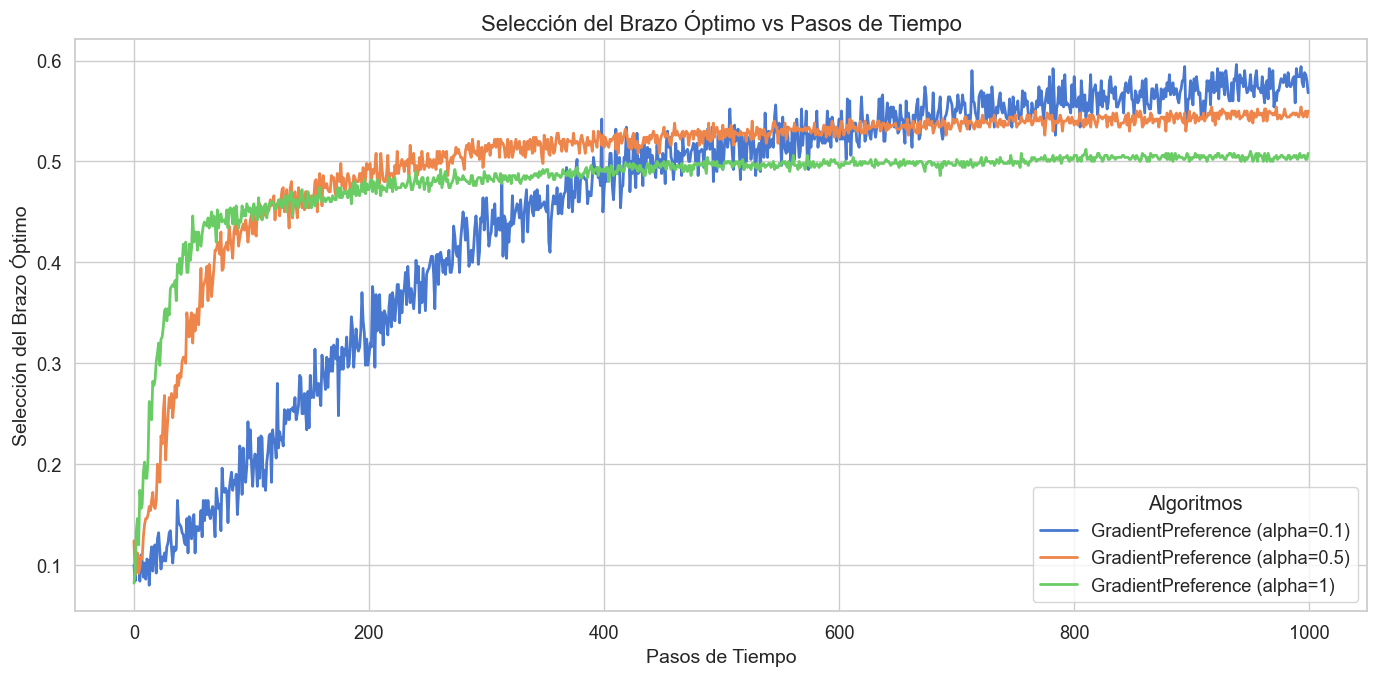

In [11]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### Análisis detallado de **"Selección del Brazo Óptimo vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado  **"Selección del Brazo Óptimo vs Pasos de Tiempo"**, donde se analiza el número de veces promedio que se elige el brazo óptimo  en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el promedio de **selecciones del brazo óptimo** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones. Por lo que será complicado que esta estrategia elija el brazo óptimo a no ser que lo elija en una primera instancia; ya que se dedicara a explotar el brazo elegido inicialmente.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración). Esto ayudará a no solo realizar explotación, sino también realizar exploración para encontrar el brazo óptimo.
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Selección del brazo óptimo:**
   - La línea **verde (ε=0.1)** alcanza rápidamente el brazo óptimo lo que indica que la estrategia con mayor exploración aprende más rápido cuál es el brazo óptimo y una vez conocido como sabe que es el que mejor recompensa promedio le puede dar, pues comienza a explotar esa opción.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1. Por lo que tardaría algo más en encontrar el brazo óptimo, pero también lo encontraría y lo comenzaría a explotar aunque más tardamente; haciendo así que tenga un menor número de tiradas de dicho brazo.
   - La línea **azul (ε=0)** al no tener exploración no logra encontrar el mejor brazo porque no explora nuevas opciones, por lo que nunca tira del brazo optimo y se dedica a explotar el brazo elegido inicialmente.

   Lo más destacable que notamos es que respecto a la distribución normal el brazo óptimo de promedio es elegido en una menor frecuencia, aunque esto se puede deber simplemente al componente de aleatoriedad de la exploración, haciendo que le costara más o empezar a explorar o en sí encontrar el mejor brazo.

---

#### Estadisticas de los brazos

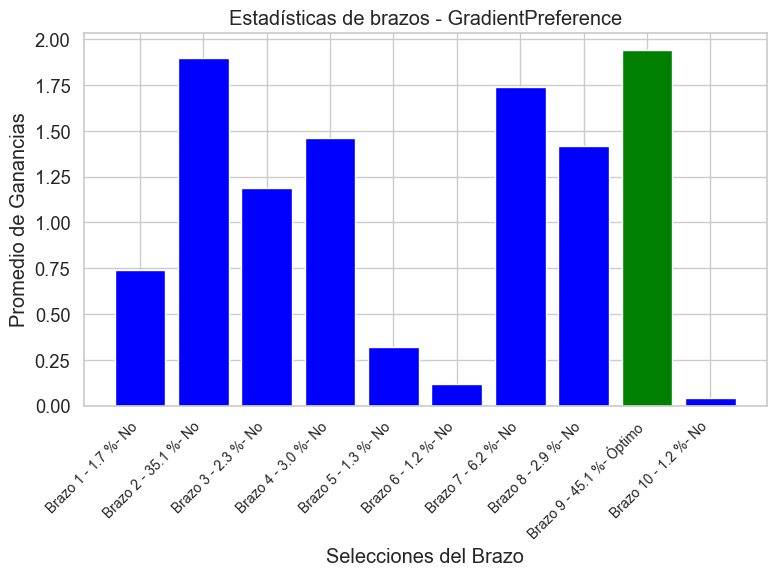

Recompensa Promedio del Brazo 1 : 0.74
Recompensa Promedio del Brazo 2 : 1.9
Recompensa Promedio del Brazo 3 : 1.19
Recompensa Promedio del Brazo 4 : 1.46
Recompensa Promedio del Brazo 5 : 0.32
Recompensa Promedio del Brazo 6 : 0.12
Recompensa Promedio del Brazo 7 : 1.74
Recompensa Promedio del Brazo 8 : 1.42
Recompensa Promedio del Brazo 9 : 1.94
Recompensa Promedio del Brazo 10 : 0.04


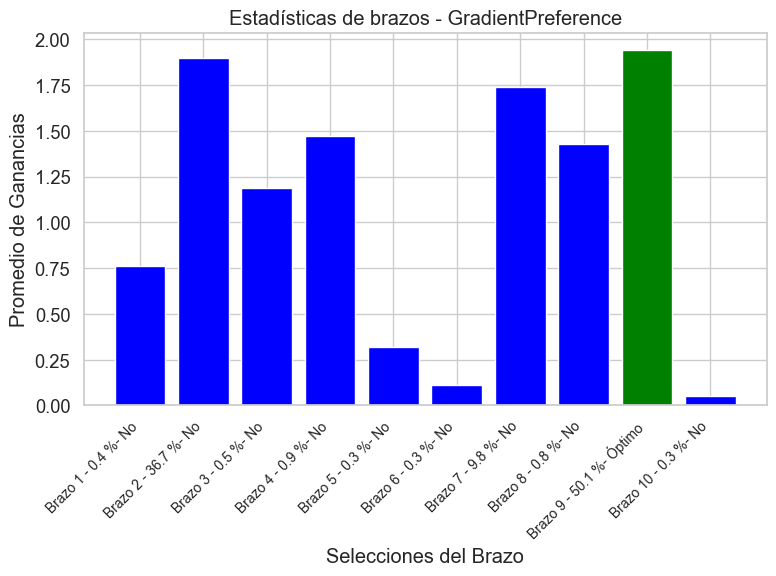

Recompensa Promedio del Brazo 1 : 0.76
Recompensa Promedio del Brazo 2 : 1.9
Recompensa Promedio del Brazo 3 : 1.19
Recompensa Promedio del Brazo 4 : 1.47
Recompensa Promedio del Brazo 5 : 0.32
Recompensa Promedio del Brazo 6 : 0.11
Recompensa Promedio del Brazo 7 : 1.74
Recompensa Promedio del Brazo 8 : 1.43
Recompensa Promedio del Brazo 9 : 1.94
Recompensa Promedio del Brazo 10 : 0.05


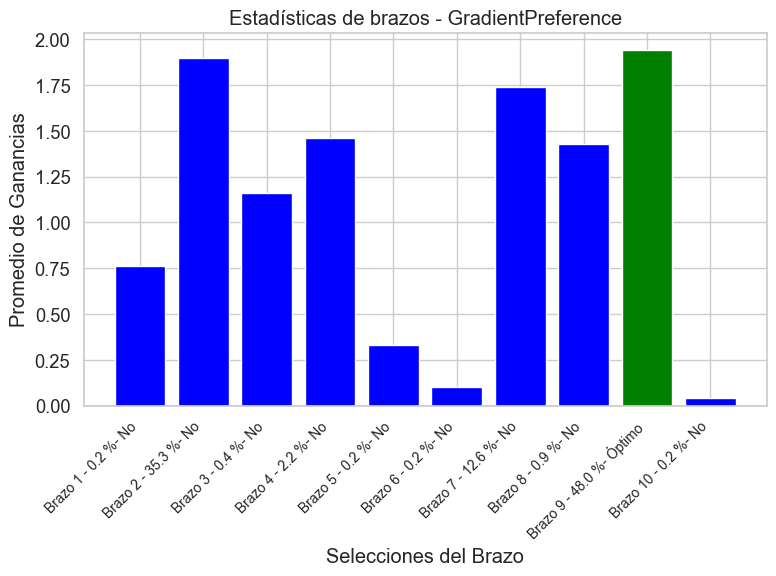

Recompensa Promedio del Brazo 1 : 0.76
Recompensa Promedio del Brazo 2 : 1.9
Recompensa Promedio del Brazo 3 : 1.16
Recompensa Promedio del Brazo 4 : 1.46
Recompensa Promedio del Brazo 5 : 0.33
Recompensa Promedio del Brazo 6 : 0.1
Recompensa Promedio del Brazo 7 : 1.74
Recompensa Promedio del Brazo 8 : 1.43
Recompensa Promedio del Brazo 9 : 1.94
Recompensa Promedio del Brazo 10 : 0.04


In [12]:
plot_arm_statistics(arm_stats, algorithms)

#### Análisis detallado de **"Estadísticas de los brazos"**

Las imágenes muestran un histograma donde podremos ver las estadísticas de los brazos, donde se analiza las estadísticas de los brazos en los algoritmos **ε-Greedy** en el problema del bandido multi-brazo. Algunas de las estadísticas que veremos serán la recompensa promedio, cuantas veces ha sido elegido cada brazo, si es el brazo óptimo y el número del brazo.


1. **Tres Histogramas que muestran las diferencias de valores de ε en el algoritmo ε-Greedy:**
   - La primera gráfica muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0, por lo que no tendrá ningún componente de exploración.
   - La segunda nos muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0.01, por lo que tendrá un 1% de probabilidad de exploración.
   - La tercera nos muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0.1, por lo que tendrá un 10% de probabilidad de exploración, haciendo así que haya un mayor componente de exploración.

2. **Estadísticas brazos**
   - En el primer histograma podemos ver el cómo el algoritmo a no tener exploración siempre se quedara en su primera opción elegida ya es que la mejor recompensa le ha dado hasta el momento. Esto se respeta para todas las ejecuciones.
   - En el segundo histograma ya podemos apreciar la exploración y el cómo se eligen una mayor cantidad de brazos y no se centra en solo explotar uno, podemos darnos cuenta de que alcanza el brazo óptimo que le otorga la mayor recompensa promedio y además es el brazo que una vez encontrado más veces se tiende a elegir dado que es el que mayor recompensa ha dado y que sabe que le seguira dando la recompensa más alta.
   - Ocurre un comportamiento similar al anterior, pero al tener un mayor porcentaje de exploración alcanza antes el brazo óptimo lo que hace que ya lo pueda elegir o explotar más veces al saber que es el brazo con la mayor recompensa que le ha dado. Y eso se ve reflejado en su porcentaje de tiradas promedio.

   Podemos darnos cuenta de que para este problema el brazo óptimo ahora es el 9, quizás por esto antes podíamos ver que obtenía menos recompensa y menos selecciones del brazo óptimo ya que al ser un brazo más alejado, porque antes era el brazo 8, quizás se le dificulte algo más a la hora de la exploración el encontrarlo. También en general el brazo óptimo no se aleja por demasiado en recompensa promedio de otros brazos, quizás esto también afecté a la búsqueda del brazo óptimo.

---

#### Evolución del arrepentimiento promedio.

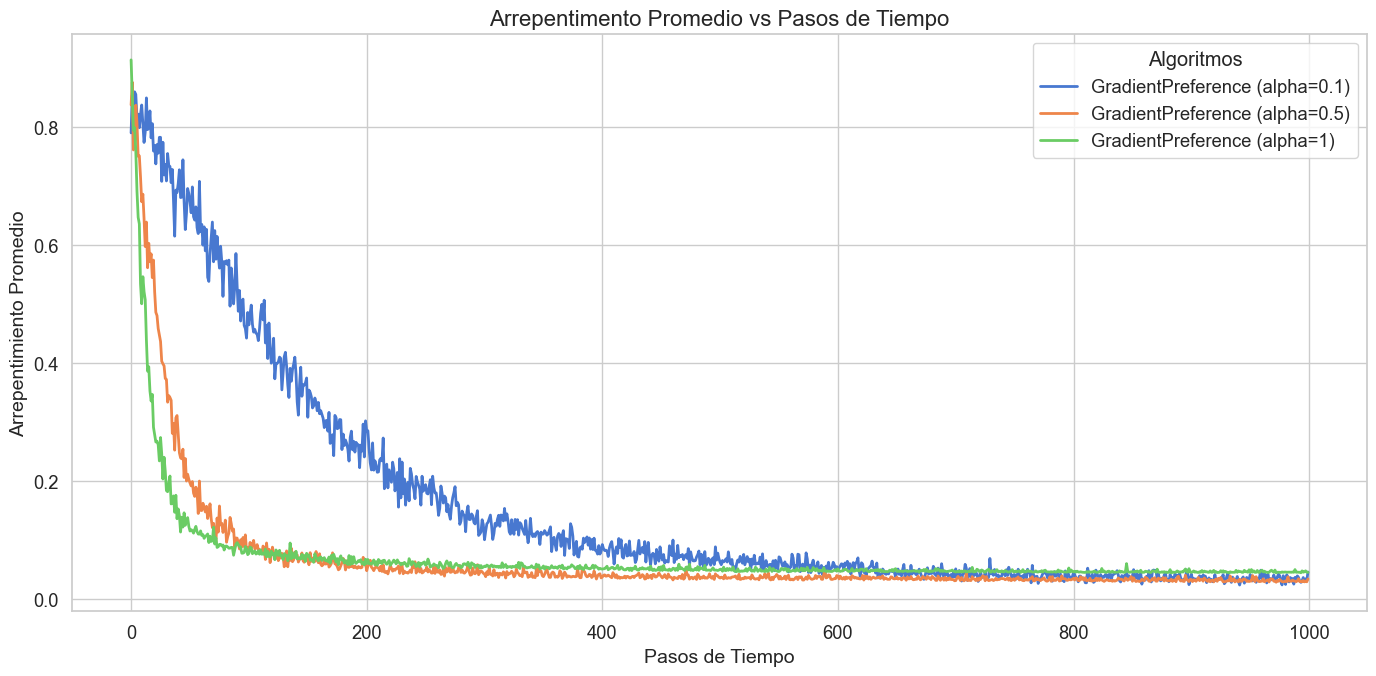

In [13]:
plot_regret(steps, regret_accumulated, algorithms)

#### Análisis detallado de **"Arrepentimiento Promedio vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado **"Arrepentimiento promedio vs Pasos de Tiempo"**, donde se analiza el arrepentimiento promedio de las estrategias del algoritmo **ε-Greedy** en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **arrepentimiento promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones. Por lo que esta estrategia difícilmente podría elegir el brazo óptimo a no ser que lo elija de primeras, lo que hará que el arrepentimiento aumente en este algoritmo; ya que al no escogerlo el arrepentimiento no decrecerá hasta que se encuentre el brazo óptimo.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Arrepentimiento promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente el brazo óptimo lo que indica que la estrategia con mayor exploración aprende más rápido qué brazo del bandit es óptimo. Esto trae como resultado que rápidamente encuentre el brazo óptimo y por ende empiece a obtener la mejor recompensa, haciendo así que su arrepentimiento decrezca rápidamente hasta estandarizarse en valores mínimos.
   - La línea **naranja (ε=0.01)** también muestra un decrecimiento, pero más lento en comparación con ε=0.1. Esto se debe a que como necesita más tiempo para encontrar el brazo óptimo, pues tirara más veces de brazos que no sean óptimos al tener un menor porcentaje de exploración, haciendo así que aumente el arrepentimiento hasta encontrar el brazo óptimo donde el arrepentimiento comienza a decrecer hasta estandarizarse en valores mínimos.
   - La línea **azul (ε=0)** al no tener exploración no logra encontrar el mejor brazo porque no explora nuevas opciones. Por lo que se mantiene con un arrepentimiento alto y de manera constante al nunca alcanzar el brazo óptimo.

---

### Conclusiones 

Hemos estudiado un **experimento de toma de decisiones secuenciales**, modelado con un **Bandido Multi-Brazzo**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandido) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **ε-Greedy** equilibra la exploración y la explotación:
- **Explotación (ε=0)**: Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.

Los gráficos confirman este comportamiento:
- **ε=0.1 (verde)** obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo y comenzar a explotarlo, además obtiene las mejores estadísticas y el arrepentimiento decrece rápidamente.
- **ε=0.01 (naranja)** explora menos, por lo que tarda más en converger a una recompensa alta y decrecer el arrepentimiento, aunque es cierto que encuentra el brazo óptimo, pero lo explota menos debido a que tarda más en encontrarlo.
- **ε=0 (azul)** no explora en absoluto y queda atrapado en una recompensa subóptima y un arrepentimiento estándar, además tiende a elegir siempre entre el brazo 1 o 2 y como no puede explorar solo se dedica a explotar el que haya elegido lo que le trae estos resultados.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor exploración (ε=0.1) alcanzan una recompensa alta más rápido y un arrepentimiento bajo más rápido. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.


#### **3. Utilidad Graficos**

El gráfico que nos muestra la recompensa promedio podemos utilizarlo para ver como los algoritmos mejoran en las recompensas obtenidas, para así hacernos a una idea de si están encontrando brazos que otorguen una buena recompensa e inclusive el brazo óptimo. Viendo el balance entre exploración y explotación nos ayuda a entender mejor el algoritmo.

La gráfica de Selección del Brazo Óptimo nos muestra la exploración y explotación, pudiendo ver así si los algoritmos encuentran el brazo óptimo y comienza a explotarlo, si realizan explotación de otros brazos o por ejemplo una falta de exploración para encontrar el brazo óptimo 

La gráfica de Estadísticas de Brazos nos muestra una serie de estadísticas de cada brazo como su porcentaje de selecciones, recompensas promedio de cada uno, su nombre o si es óptimo o no. Puede se útil para ver cuanta diferencia en recompensa promedio hay entre los brazos, si está explotando el brazo óptimo u otro brazo, la exploración o el porcentaje de selecciones de cada uno.

La gráfica del Arrepentimiento Promedio nos muestra el arrepentimiento promedio de cada uno de los algoritmos esto es útil, ya que nos ayuda a entender las elecciones de los brazos que están haciendo, si están eligiendo el brazo óptimo o si están explotando un brazo.

Las graficas más relevantes diría que son las 2 primeras. Porque con esas ya podemos hacernos a una idea de si se está seleccionando el brazo óptimo o no, si las recompensas van mejorando o no evolucionan. Entonces con estas 2 podemos básicamente hacernos a una idea de si se está eligiendo buenas opciones e inclusive se puede apreciar la falta de explotación. Las estadísticas de los brazos también es interesante aunque algo menos, lo más significativo para nosotros es el porcentaje de tiradas de cada brazo, ya que se puede apreciar muy fácilmente la explotación y la exploración. La última gráfica aunque interesante realmente no ofrece una información muy novedosa que no hayamos podido obtener con las anteriores.

#### **4. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **ε=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.
- Un detalle a comentar es que esta distribución su principal diferencia en cuanto a rendimiento respecto a la anterior es la mayor dificultad de encontrar el brazo óptimo por los motivos que se mencionan anteriormente.

En conclusión para una distribución binomial, **los gráficos muestran cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo**. 🚀 

## Distribución Bernoulli

### Ejecución del experimento

Ahora continuamos con la distribución de Bernoulli

In [14]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [GradientPreference(k=k, alpha=0.1), GradientPreference(k=k, alpha=0.5), GradientPreference(k=k, alpha=1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBenoulli(p=0.37), ArmBenoulli(p=0.95), ArmBenoulli(p=0.6), ArmBenoulli(p=0.73), ArmBenoulli(p=0.16), ArmBenoulli(p=0.06), ArmBenoulli(p=0.87), ArmBenoulli(p=0.71), ArmBenoulli(p=0.97), ArmBenoulli(p=0.02)
Optimal arm: 9 with expected reward=0.97


### Visualización de los resultados

#### Evolución Recompensa Promedio

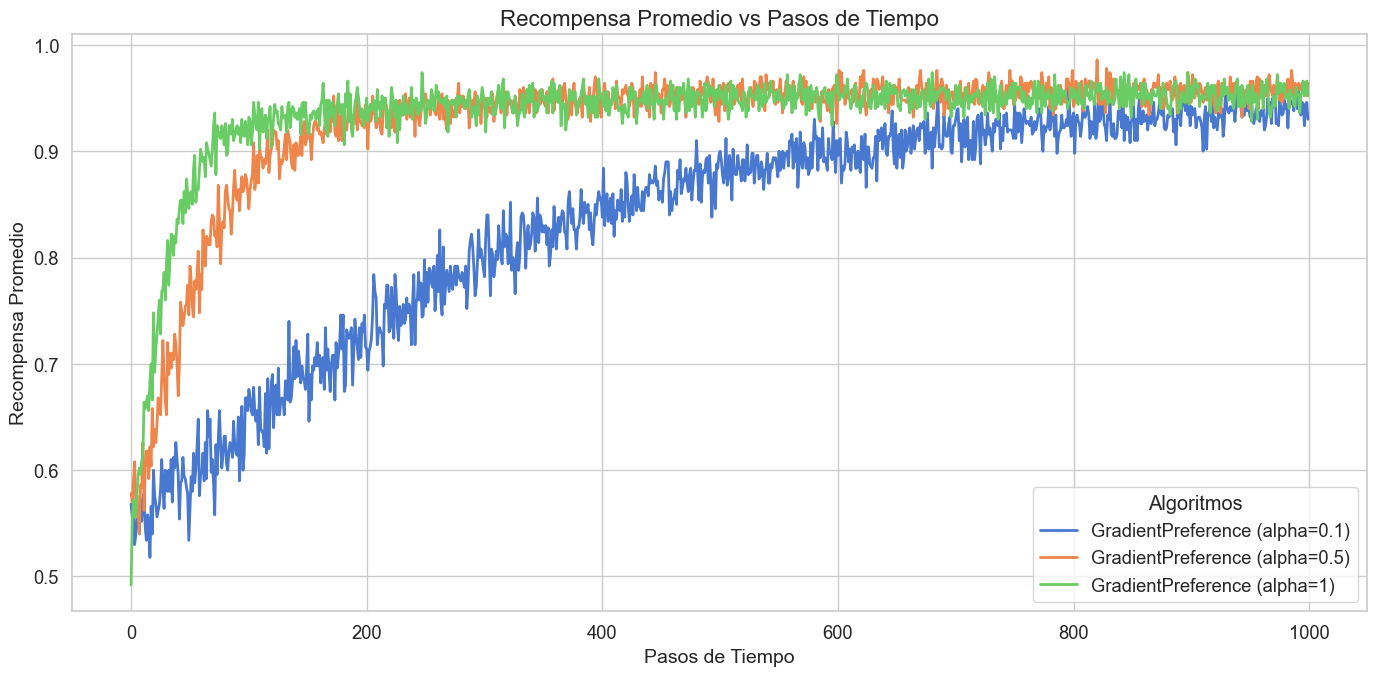

In [15]:
plot_average_rewards(steps, rewards, algorithms)

#### Análisis detallado de **"Recompensa Promedio vs Pasos de Tiempo"**
La imagen muestra un gráfico titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno del problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo o steps**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración). Esto ayudará a no explotar un mismo brazo y buscar más brazos que puedan maximizar la recompensa.
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1.
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.

   Destacar que como la distribución de Bernoulli es un caso especial para la distribución Binomial, pues al menos en esta gráfica los resultados son similares.

---

#### Evolución Selección Brazo Optimo


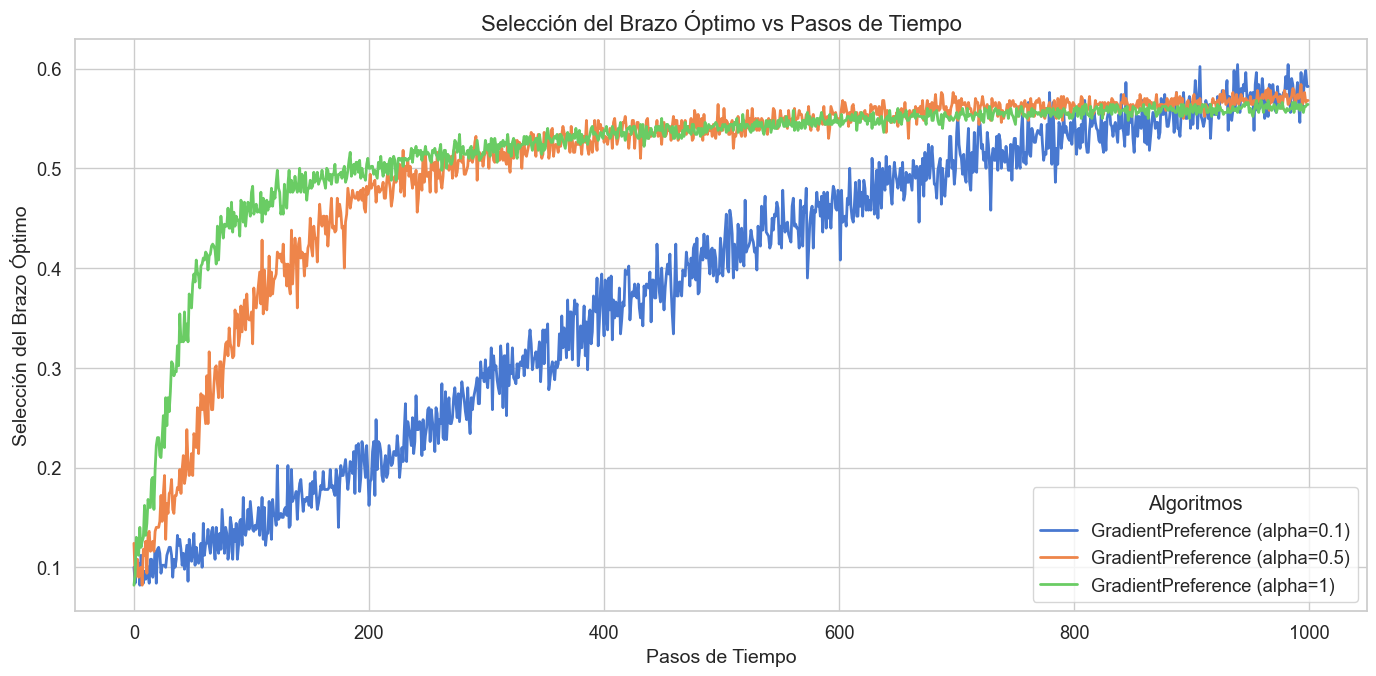

In [16]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### Análisis detallado de **"Selección del Brazo Óptimo vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado  **"Selección del Brazo Óptimo vs Pasos de Tiempo"**, donde se analiza el número de veces promedio que se elige el brazo óptimo  en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el promedio de **selecciones del brazo óptimo** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones. Por lo que será complicado que esta estrategia elija el brazo óptimo a no ser que lo elija en una primera instancia; ya que se dedicara a explotar el brazo elegido inicialmente.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración). Esto ayudará a no solo realizar explotación, sino también realizar exploración para encontrar el brazo óptimo.
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Selección del brazo óptimo:**
   - La línea **verde (ε=0.1)** alcanza rápidamente el brazo óptimo lo que indica que la estrategia con mayor exploración aprende más rápido cuál es el brazo óptimo y una vez conocido como sabe que es el que mejor recompensa promedio le puede dar, pues comienza a explotar esa opción. Aunque menos que en experimentos previos
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1. Por lo que tardaría algo más en encontrar el brazo óptimo, pero también lo encontraría y lo comenzaría a explotar aunque más tardamente; haciendo así que tenga un menor número de tiradas de dicho brazo.
   - La línea **azul (ε=0)** al no tener exploración no logra encontrar el mejor brazo porque no explora nuevas opciones, por lo que nunca tira del brazo optimo y se dedica a explotar el brazo elegido inicialmente.


 Detalle interesante que de los 3 es el algoritmo que menos veces selecciona el brazo óptimo, esto se puede deber a la aleatoriedad de la exploración, por lo que quizás tarde más simplemente pura aleatoriedad o por la semilla en sí en descubrir el brazo óptimo.

---

#### Estadisticas de los brazos

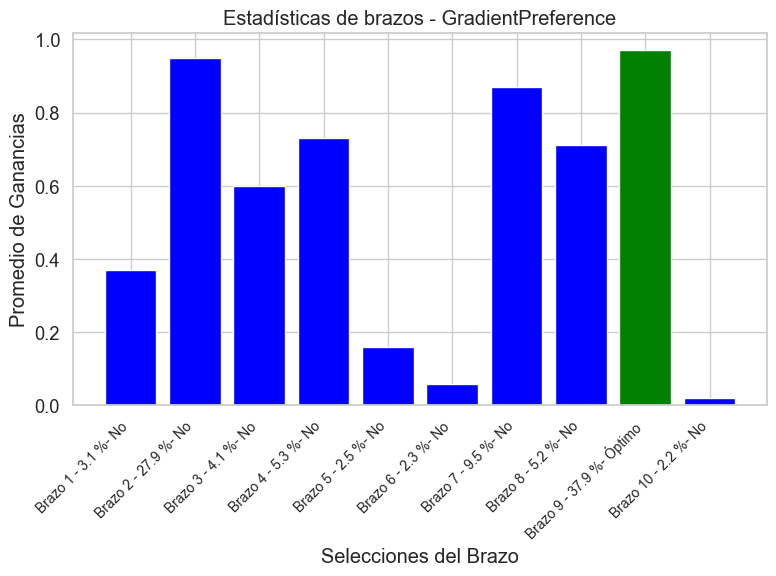

Recompensa Promedio del Brazo 1 : 0.37
Recompensa Promedio del Brazo 2 : 0.95
Recompensa Promedio del Brazo 3 : 0.6
Recompensa Promedio del Brazo 4 : 0.73
Recompensa Promedio del Brazo 5 : 0.16
Recompensa Promedio del Brazo 6 : 0.06
Recompensa Promedio del Brazo 7 : 0.87
Recompensa Promedio del Brazo 8 : 0.71
Recompensa Promedio del Brazo 9 : 0.97
Recompensa Promedio del Brazo 10 : 0.02


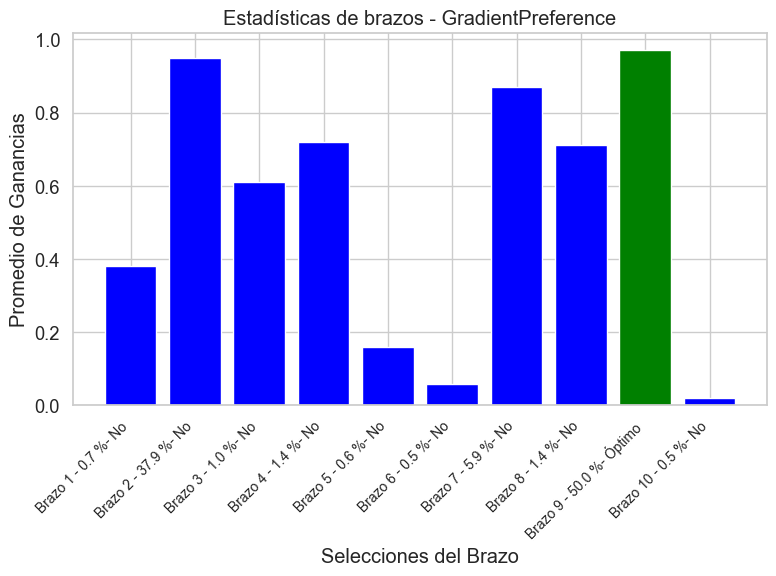

Recompensa Promedio del Brazo 1 : 0.38
Recompensa Promedio del Brazo 2 : 0.95
Recompensa Promedio del Brazo 3 : 0.61
Recompensa Promedio del Brazo 4 : 0.72
Recompensa Promedio del Brazo 5 : 0.16
Recompensa Promedio del Brazo 6 : 0.06
Recompensa Promedio del Brazo 7 : 0.87
Recompensa Promedio del Brazo 8 : 0.71
Recompensa Promedio del Brazo 9 : 0.97
Recompensa Promedio del Brazo 10 : 0.02


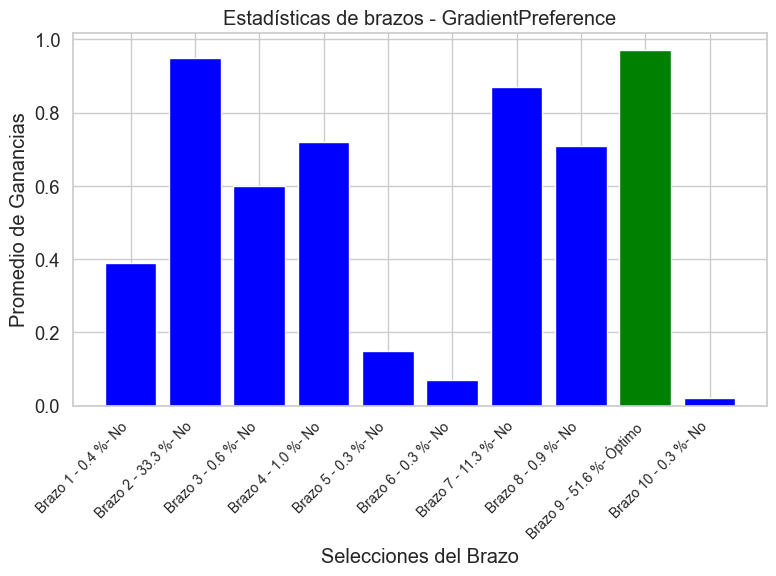

Recompensa Promedio del Brazo 1 : 0.39
Recompensa Promedio del Brazo 2 : 0.95
Recompensa Promedio del Brazo 3 : 0.6
Recompensa Promedio del Brazo 4 : 0.72
Recompensa Promedio del Brazo 5 : 0.15
Recompensa Promedio del Brazo 6 : 0.07
Recompensa Promedio del Brazo 7 : 0.87
Recompensa Promedio del Brazo 8 : 0.71
Recompensa Promedio del Brazo 9 : 0.97
Recompensa Promedio del Brazo 10 : 0.02


In [17]:
plot_arm_statistics(arm_stats, algorithms)

#### Análisis detallado de **"Estadísticas de los brazos"**

Las imágenes muestran un histograma donde podremos ver las estadísticas de los brazos, donde se analiza las estadísticas de los brazos en los algoritmos **ε-Greedy** en el problema del bandido multi-brazo. Algunas de las estadísticas que veremos serán la recompensa promedio, cuantas veces ha sido elegido cada brazo, si es el brazo óptimo y el número del brazo.


1. **Tres Histogramas que muestran las diferencias de valores de ε en el algoritmo ε-Greedy:**
   - La primera gráfica muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0, por lo que no tendrá ningún componente de exploración.
   - La segunda nos muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0.01, por lo que tendrá un 1% de probabilidad de exploración.
   - La tercera nos muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0.1, por lo que tendrá un 10% de probabilidad de exploración, haciendo así que haya un mayor componente de exploración.

2. **Estadísticas brazos**
   - En el primer histograma podemos ver el cómo el algoritmo a no tener exploración siempre se quedara en su primera opción elegida ya es que la mejor recompensa le ha dado hasta el momento. 
   - En el segundo histograma ya podemos apreciar la exploración y el cómo se eligen una mayor cantidad de brazos y no se centra en solo explotar uno, podemos darnos cuenta de que alcanza el brazo óptimo que le otorga la mayor recompensa promedio y además es el brazo que una vez encontrado más veces se tiende a elegir dado que es el que mayor recompensa ha dado y que sabe que le seguira dando la recompensa más alta.
   - Ocurre un comportamiento similar al anterior, pero al tener un mayor porcentaje de exploración alcanza antes el brazo óptimo lo que hace que ya lo pueda elegir o explotar más veces al saber que es el brazo con la mayor recompensa que le ha dado. Y eso se ve reflejado en su porcentaje de tiradas promedio.

   Resultados simlilares al anterior experimento.

---

#### Evolución del arrepentimiento promedio.

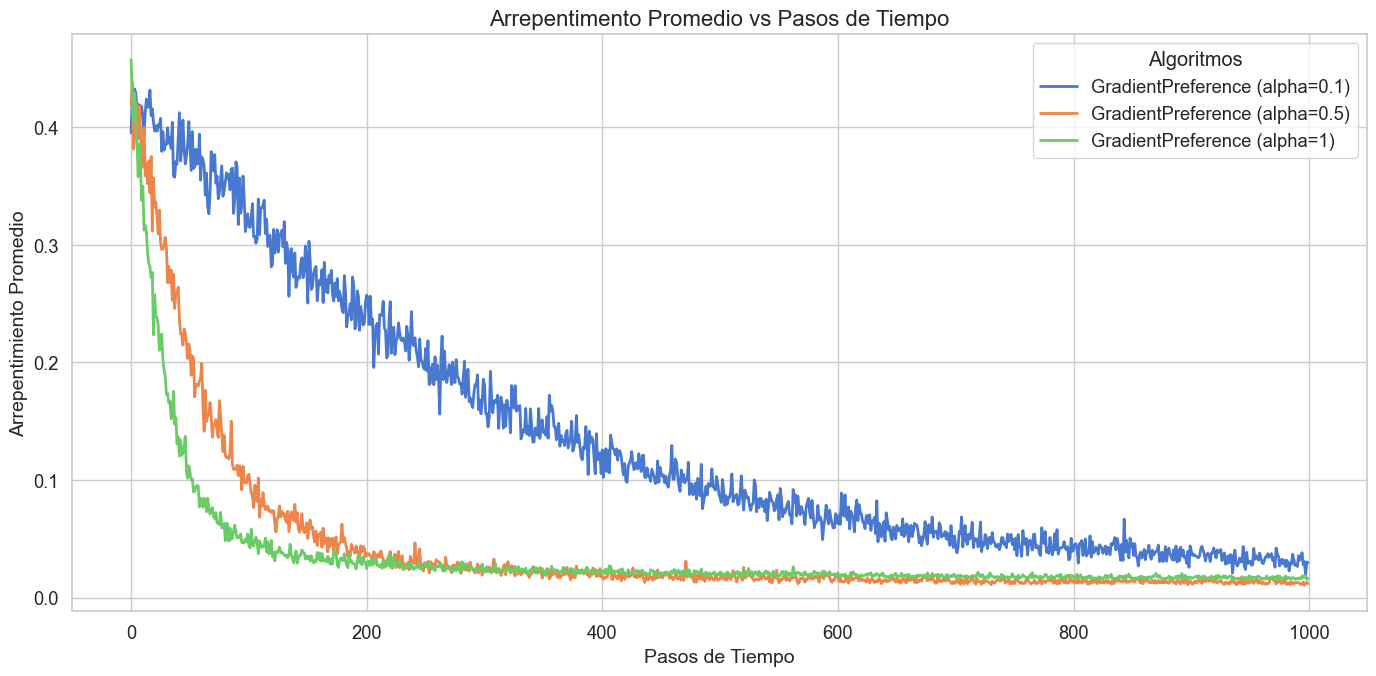

In [18]:
plot_regret(steps, regret_accumulated, algorithms)

#### Análisis detallado de **"Arrepentimiento Promedio vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado **"Arrepentimiento promedio vs Pasos de Tiempo"**, donde se analiza el arrepentimiento promedio de las estrategias del algoritmo **ε-Greedy** en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **arrepentimiento promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones. Por lo que esta estrategia difícilmente podría elegir el brazo óptimo a no ser que lo elija de primeras, lo que hará que el arrepentimiento aumente en este algoritmo; ya que al no escogerlo el arrepentimiento no decrecerá hasta que se encuentre el brazo óptimo.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Arrepentimiento promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente el brazo óptimo lo que indica que la estrategia con mayor exploración aprende más rápido qué brazo del bandit es óptimo. Esto trae como resultado que rápidamente encuentre el brazo óptimo y por ende empiece a obtener la mejor recompensa, haciendo así que su arrepentimiento decrezca rápidamente hasta estandarizarse en valores mínimos.
   - La línea **naranja (ε=0.01)** también muestra un decrecimiento, pero más lento en comparación con ε=0.1. Esto se debe a que como necesita más tiempo para encontrar el brazo óptimo, pues tirara más veces de brazos que no sean óptimos al tener un menor porcentaje de exploración, haciendo así que aumente el arrepentimiento hasta encontrar el brazo óptimo donde el arrepentimiento comienza a decrecer hasta estandarizarse en valores mínimos.
   - La línea **azul (ε=0)** al no tener exploración no logra encontrar el mejor brazo porque no explora nuevas opciones. Por lo que se mantiene con un arrepentimiento alto y de manera constante al nunca alcanzar el brazo óptimo.

---

### Conclusiones 

Hemos estudiado un **experimento de toma de decisiones secuenciales**, modelado con un **Bandido Multi-Brazzo**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandido) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **ε-Greedy** equilibra la exploración y la explotación:
- **Explotación (ε=0)**: Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.

Los gráficos confirman este comportamiento:
- **ε=0.1 (verde)** obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo y comenzar a explotarlo, además obtiene las mejores estadísticas y el arrepentimiento decrece rápidamente.
- **ε=0.01 (naranja)** explora menos, por lo que tarda más en converger a una recompensa alta y decrecer el arrepentimiento, aunque es cierto que encuentra el brazo óptimo, pero lo explota menos debido a que tarda más en encontrarlo.
- **ε=0 (azul)** no explora en absoluto y queda atrapado en una recompensa subóptima y un arrepentimiento estándar, además tiende a elegir siempre entre el brazo 1 o 2 y como no puede explorar solo se dedica a explotar el que haya elegido lo que le trae estos resultados.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor exploración (ε=0.1) alcanzan una recompensa alta más rápido y un arrepentimiento bajo más rápido. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.


#### **3. Utilidad Graficos**

El gráfico que nos muestra la recompensa promedio podemos utilizarlo para ver como los algoritmos mejoran en las recompensas obtenidas, para así hacernos a una idea de si están encontrando brazos que otorguen una buena recompensa e inclusive el brazo óptimo. Viendo el balance entre exploración y explotación nos ayuda a entender mejor el algoritmo.

La gráfica de Selección del Brazo Óptimo nos muestra la exploración y explotación, pudiendo ver así si los algoritmos encuentran el brazo óptimo y comienza a explotarlo, si realizan explotación de otros brazos o por ejemplo una falta de exploración para encontrar el brazo óptimo 

La gráfica de Estadísticas de Brazos nos muestra una serie de estadísticas de cada brazo como su porcentaje de selecciones, recompensas promedio de cada uno, su nombre o si es óptimo o no. Puede se útil para ver cuanta diferencia en recompensa promedio hay entre los brazos, si está explotando el brazo óptimo u otro brazo, la exploración o el porcentaje de selecciones de cada uno.

La gráfica del Arrepentimiento Promedio nos muestra el arrepentimiento promedio de cada uno de los algoritmos esto es útil, ya que nos ayuda a entender las elecciones de los brazos que están haciendo, si están eligiendo el brazo óptimo o si están explotando un brazo.

Las graficas más relevantes diría que son las 2 primeras. Porque con esas ya podemos hacernos a una idea de si se está seleccionando el brazo óptimo o no, si las recompensas van mejorando o no evolucionan. Entonces con estas 2 podemos básicamente hacernos a una idea de si se está eligiendo buenas opciones e inclusive se puede apreciar la falta de explotación. Las estadísticas de los brazos también es interesante aunque algo menos, lo más significativo para nosotros es el porcentaje de tiradas de cada brazo, ya que se puede apreciar muy fácilmente la explotación y la exploración. La última gráfica aunque interesante realmente no ofrece una información muy novedosa que no hayamos podido obtener con las anteriores.

#### **4. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **ε=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.
- Un detalle a comentar es que esta distribución su principal diferencia en cuanto a rendimiento respecto a la anterior es la mayor dificultad de encontrar el brazo óptimo por los motivos que se mencionan anteriormente.

En conclusión para una distribución de bernoulli, **los gráficos muestran cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo**. 🚀

## Conclusiones de la prueba

Las conclusiones que podemos sacar son bastante obvias, el introducir un componente de exploración adecuado permite el obtener unas mejores recompensas promedio, así como baja el arrepentimiento; ya que el tener un componente suficiente de exploración nos asegura el alcanzar el brazo óptimo rápidamente, mejorando así el rendimiento del algoritmo. Esto se traduce básicamente en un mejor desempeño y resolución del problema del bandido multi-brazo. Esto se ha respetado a lo largo de los 3 experimentos. Es más como se ha podido vez ya solo el introducir un 1% de porcentaje de exploración hace que el algoritmo mejore sustancialmente respecto a no tener nada de exploración, por lo que realizar solo explotación no es una alternativa viable. En líneas generales también parece que el algoritmo epsilon-greedy es un algoritmo muy efectivo en este problema e inclusive margen de maniobra, ya que aún se podría seguir jugando con valores de épsilon para obtener otros resultados, con diferentes porcentajes de exploración que podrían beneficiar o empeorar el algoritmo dependiendo de la situación. 

Por último comentar que los resultados obtenidos para los 3 bandidos son muy similares en evolución del rendimiento del mismo. Variando por ejemplo que las recompensas promedio de los 2 últimos eran más bajas por como se calculan dichas recompensas y un detalle más interesante es que en estos 2 últimos hay un menor porcentaje de selección del brazo óptimo, esto puede deberse a la aleatoriedad de la exploración, ya que se le dificulta más explorar por la semilla elegida, tal vez por como están generadas las recompensas también le pueda afectar y además el hecho del que brazo óptimo este más lejos del brazo de inicio, que como hemos visto para estas distribuciones el brazo óptimo era el 9. Aun con todo en todos los experimentos se obtienen buenos resultados y mismas conclusiones.